#### Import Libraries

In [231]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from pyclustertend import hopkins
from sklearn.preprocessing import scale
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_samples,silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

#### Load Dataset

In [232]:
df = pd.read_csv("cars_clus.csv")
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


# Exploratory Data Analysis

In [233]:
# Dublicate row var mi bakilir?
df.duplicated().sum()

0

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   manufact   157 non-null    object 
 1   model      159 non-null    object 
 2   sales      159 non-null    object 
 3   resale     159 non-null    object 
 4   type       159 non-null    object 
 5   price      159 non-null    object 
 6   engine_s   159 non-null    object 
 7   horsepow   159 non-null    object 
 8   wheelbas   159 non-null    object 
 9   width      159 non-null    object 
 10  length     159 non-null    object 
 11  curb_wgt   159 non-null    object 
 12  fuel_cap   159 non-null    object 
 13  mpg        159 non-null    object 
 14  lnsales    159 non-null    object 
 15  partition  159 non-null    float64
dtypes: float64(1), object(15)
memory usage: 20.0+ KB


In [235]:
df.columns

Index(['manufact', 'model', 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales', 'partition'],
      dtype='object')

In [236]:
num_list=['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']
for i in num_list:
    df[i]=pd.to_numeric(df[i],errors='coerce') 
    #If 'coerce', then invalid parsing will be set as NaN.

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   manufact   157 non-null    object 
 1   model      159 non-null    object 
 2   sales      157 non-null    float64
 3   resale     121 non-null    float64
 4   type       157 non-null    float64
 5   price      157 non-null    float64
 6   engine_s   158 non-null    float64
 7   horsepow   158 non-null    float64
 8   wheelbas   158 non-null    float64
 9   width      158 non-null    float64
 10  length     158 non-null    float64
 11  curb_wgt   157 non-null    float64
 12  fuel_cap   158 non-null    float64
 13  mpg        156 non-null    float64
 14  lnsales    157 non-null    float64
 15  partition  159 non-null    float64
dtypes: float64(14), object(2)
memory usage: 20.0+ KB


In [238]:
df.replace('$null$',np.nan,inplace=True)

In [239]:
df[df.manufact.isnull()]

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
157,NaN,newCar,NaN,NaN,NaN,21.5,1.5,76.0,106.3,67.9,175.0,2.932,11.9,46.0,NaN,1.0
158,NaN,newTruck,NaN,NaN,NaN,34.2,3.5,167.0,109.8,75.2,188.4,4.508,17.2,26.0,NaN,1.0


In [240]:
df.dropna(subset=['manufact','price'],inplace=True)

In [241]:
df.drop('partition',axis=1,inplace=True)

In [242]:
df[df.mpg.isnull()]

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales
38,Dodge,Intrepid,88.028,12.275,0.0,22.505,2.7,202.0,113.0,74.7,203.7,3.489,17.0,NaN,4.478
109,Oldsmobile,Intrigue,38.554,NaN,0.0,24.150,3.5,215.0,109.0,73.6,195.9,3.455,18.0,NaN,3.652


In [243]:
def null_values(df):
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

null_values(df)

,Missing_Records,Percentage (%)
resale,36,23.225806
mpg,2,1.290323
curb_wgt,1,0.645161


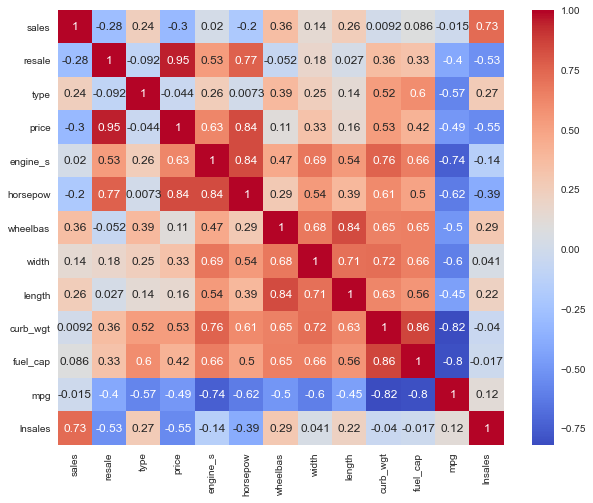

In [244]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm',annot=True);

In [245]:
df.drop('resale',axis=1,inplace=True) # 'resale' is correlated with price. So we can drop it.

In [246]:
df.dropna(inplace=True)

In [247]:
null_values(df)

,Missing_Records,Percentage (%)


In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 0 to 156
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   manufact  152 non-null    object 
 1   model     152 non-null    object 
 2   sales     152 non-null    float64
 3   type      152 non-null    float64
 4   price     152 non-null    float64
 5   engine_s  152 non-null    float64
 6   horsepow  152 non-null    float64
 7   wheelbas  152 non-null    float64
 8   width     152 non-null    float64
 9   length    152 non-null    float64
 10  curb_wgt  152 non-null    float64
 11  fuel_cap  152 non-null    float64
 12  mpg       152 non-null    float64
 13  lnsales   152 non-null    float64
dtypes: float64(12), object(2)
memory usage: 17.8+ KB


In [249]:
print('Unique Values of Each Features:\n')
for i in df:
    print(f'{i}:\n{sorted(df[i].unique())}\n')

Unique Values of Each Features:

manufact:
['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'Ford', 'Honda', 'Hyundai', 'Infiniti', 'Jaguar', 'Jeep', 'Lexus', 'Lincoln', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Saab', 'Saturn', 'Subaru', 'Toyota', 'Volkswagen', 'Volvo']

model:
['3000GT', '300M', '323i', '328i', '4Runner', '528i', '9-3', '9-5', 'A4', 'A6', 'A8', 'Accent', 'Accord', 'Alero', 'Altima', 'Aurora', 'Avalon', 'Avenger', 'Beetle', 'Bonneville', 'Boxter', 'Bravada', 'Breeze', 'C-Class', 'C70', 'CL500', 'CLK Coupe', 'CR-V', 'Cabrio', 'Camaro', 'Camry', 'Caravan', 'Carrera Cabriolet', 'Carrera Coupe', 'Catera', 'Cavalier', 'Celica', 'Century', 'Cherokee', 'Cirrus', 'Civic', 'Concorde', 'Continental', 'Contour', 'Corolla', 'Corvette', 'Cougar', 'Crown Victoria', 'Cutlass', 'Dakota', 'DeVille', 'Diamante', 'Durango', 'E-Class', 'ES300', 'Eclipse', 'Elantra', 'Eldorado', 'Escalade', 'Escort',

In [250]:
# her columns in num of uniques

df.apply(lambda x: x.nunique())

manufact     30
model       151
sales       152
type          2
price       149
engine_s     31
horsepow     65
wheelbas     88
width        77
length      124
curb_wgt    144
fuel_cap     55
mpg          22
lnsales     146
dtype: int64

In [251]:
df.describe()

,sales,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,53.359072,0.263158,27.331822,3.049342,184.809211,107.413816,71.088816,187.059211,3.376184,17.959211,23.841447,3.288967
std,68.938380,0.441803,14.418669,1.049818,56.823152,7.717839,3.464666,13.471247,0.636593,3.937582,4.304802,1.333184
min,0.110000,0.000000,9.235000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,-2.207000
25%,13.714000,0.000000,17.888750,2.300000,147.500000,102.900000,68.375000,177.475000,2.964750,15.775000,21.000000,2.618750
50%,29.213000,0.000000,22.747000,3.000000,175.000000,107.000000,70.400000,186.650000,3.336000,17.200000,24.000000,3.374500
75%,68.069750,1.000000,31.938750,3.575000,211.250000,112.200000,73.100000,195.125000,3.821500,19.800000,26.000000,4.220750
max,540.561000,1.000000,85.500000,8.000000,450.000000,138.700000,79.900000,224.500000,5.572000,32.000000,45.000000,6.293000


In [252]:
# categorik verilerin istatistiksel analizi icin:
df.describe(include=['O'])

,manufact,model
count,152,152
unique,30,151
top,Ford,Neon
freq,11,2


In [253]:
# Hem kategorik hem numeric describe daha efektiftir.
df.describe(include='all', percentiles=[.1, .25, .5, .75, .95])

,manufact,model,sales,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales
count,152,152,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
unique,30,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Ford,Neon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,11,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,53.359072,0.263158,27.331822,3.049342,184.809211,107.413816,71.088816,187.059211,3.376184,17.959211,23.841447,3.288967
std,NaN,NaN,68.938380,0.441803,14.418669,1.049818,56.823152,7.717839,3.464666,13.471247,0.636593,3.937582,4.304802,1.333184
min,NaN,NaN,0.110000,0.000000,9.235000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,-2.207000
10%,NaN,NaN,5.275600,0.000000,13.962700,1.910000,120.000000,98.450000,66.900000,172.520000,2.596300,13.200000,18.100000,1.662600
25%,NaN,NaN,13.714000,0.000000,17.888750,2.300000,147.500000,102.900000,68.375000,177.475000,2.964750,15.775000,21.000000,2.618750
50%,NaN,NaN,29.213000,0.000000,22.747000,3.000000,175.000000,107.000000,70.400000,186.650000,3.336000,17.200000,24.000000,3.374500


* Yukarida min-%10 ve max-%95 mukayesesi yaparak outliers tespiti yapilabilir.
* Maximum sales a bakildiginda outlier oldugu tespit edildi.

In [254]:
df.drop(df[df.sales==df.sales.max()].index,axis=0,inplace=True)

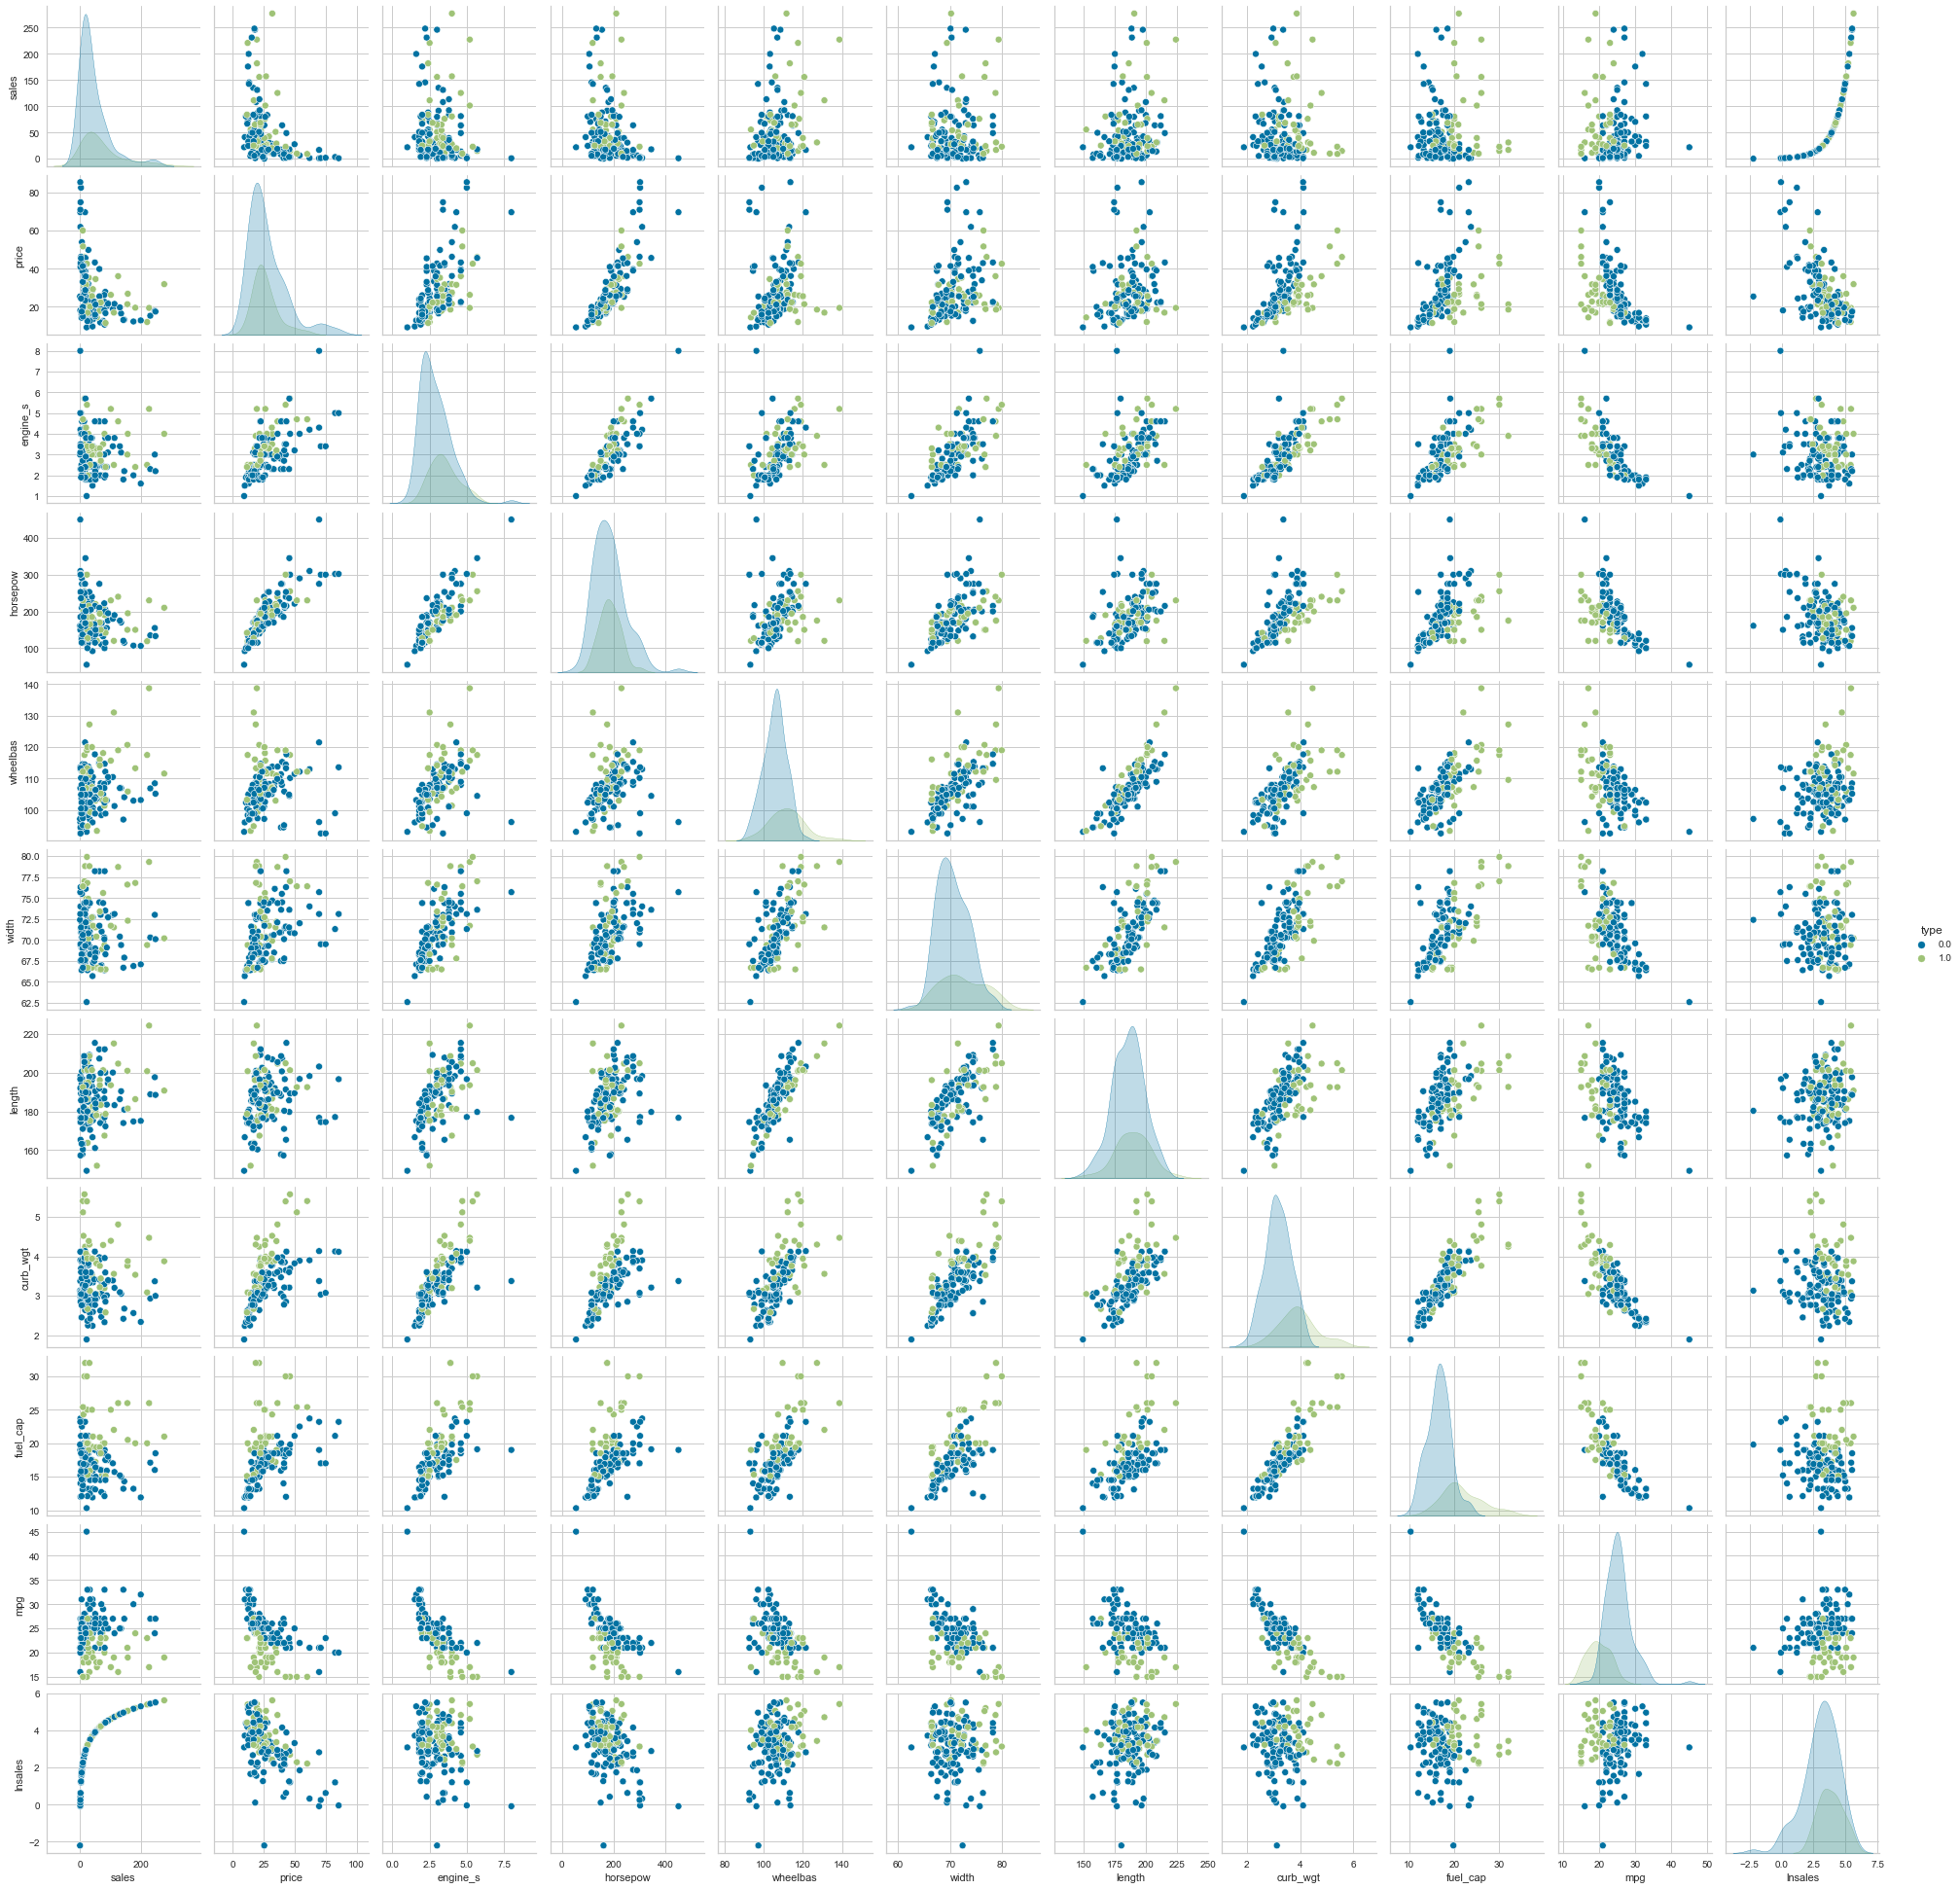

In [255]:
sns.pairplot(df,hue='type');

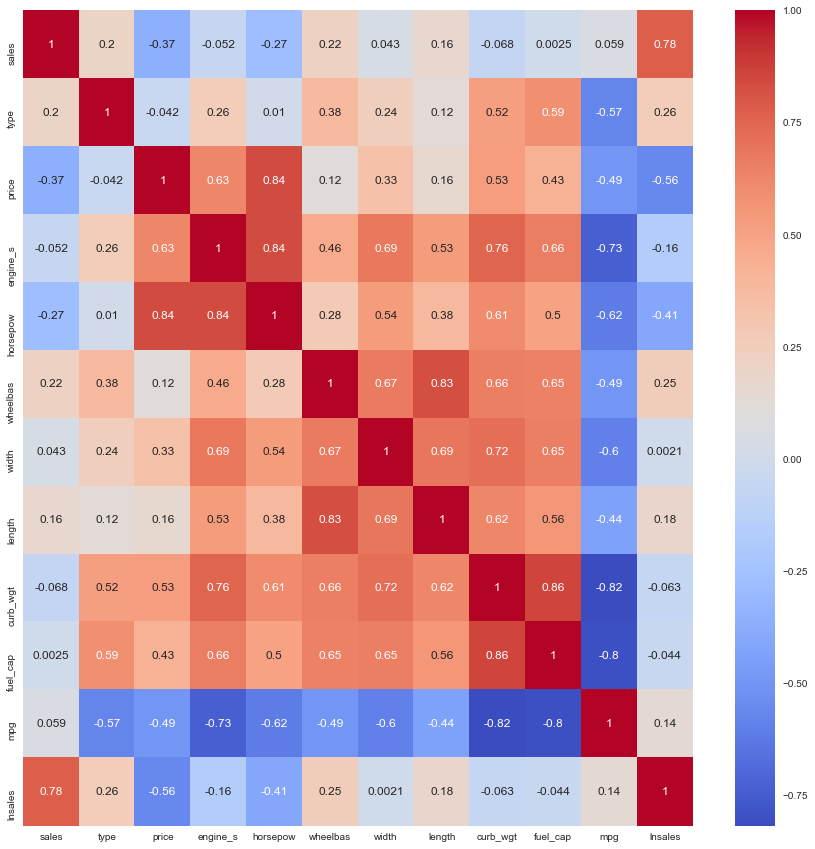

In [256]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True, cmap="coolwarm");

In [257]:
# her columns in num of uniques

df.apply(lambda x: x.nunique())

manufact     30
model       150
sales       151
type          2
price       148
engine_s     31
horsepow     65
wheelbas     87
width        76
length      123
curb_wgt    143
fuel_cap     54
mpg          22
lnsales     145
dtype: int64

In [258]:
# Drop categorical columns
df.drop(['manufact','model','type'],axis=1,inplace=True)

In [259]:
df.head()

,sales,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales
0,16.919,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828
1,39.384,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673
3,8.588,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150
4,20.397,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015
5,18.780,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933


---
---

## 3. Cluster Analysis

**Hopkins Test**
* Null Hypothesis(Ho) ve Alternative Hypothesis(Ha) temeline dayaniyor.
* Null Hypothesis(Ho): Uniform dagilim var, anlamli kümeleme yok.
* Alternative Hypothesis(Ha):  Veri, ratsgele veri noktalarindan oluşur. Yani Kumeleme vardir.
* [0,1] araliginda bir score verir. score, 0’a yaklaştıkça veri uniform degil,yani clusteringe meyilli
* 1’e yaklaştıkça uniform yapi var, 0.5 gecmedikce kümelenebilir olarak ifade edilir. pratikte 0.3 sinir alinir.

In [260]:
from pyclustertend import hopkins
hopkins(df,df.shape[0])

0.17730895287814913

In [261]:
hopkins(scale(df),df.shape[0])

0.18121036884536856

**Lets find k value given the highest Silhouette Score**

**`S(Silhouette) Score`**
* her veri için iki uzaklığı baz alır. Bu uzaklıklardan ilki verinin bulunduğu kümeye ait diğer verilere olan uzaklıkların ortalamasıdır. İkincisi veriye en yakin komsu kümenin tum verilerine olan uzaklıkların ortalamasıdır.
* S değeri ile ifade edilir, s, 1’e yakinsa high clustering, -1e yakinsa low clustering eğilimi gosterir.

In [262]:
ssd =[]

K = range(2,10)

for k in K:
    model = KMeans(n_clusters=k)
    model.fit(df)
    ssd.append(model.inertia_)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(df, model.labels_)}')

Silhouette Score for 2 clusters: 0.323405390480768
Silhouette Score for 3 clusters: 0.404444465551474
Silhouette Score for 4 clusters: 0.34580920352101957
Silhouette Score for 5 clusters: 0.35317576485951274
Silhouette Score for 6 clusters: 0.31908821780039176
Silhouette Score for 7 clusters: 0.3283695342703059
Silhouette Score for 8 clusters: 0.3218166518669871
Silhouette Score for 9 clusters: 0.3363384848598346


**k=2 gives the highest S Score**

**`S(Silhouette) Score with scaled data`**

In [263]:
ssd =[]

K = range(2,10)

for k in K:
    model = KMeans(n_clusters=k)
    model.fit(scale(df))
    ssd.append(model.inertia_)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(scale(df), model.labels_)}')

Silhouette Score for 2 clusters: 0.2888639185245622
Silhouette Score for 3 clusters: 0.2718031276859463
Silhouette Score for 4 clusters: 0.23445969822719817
Silhouette Score for 5 clusters: 0.23062740259633255
Silhouette Score for 6 clusters: 0.2140952640587939
Silhouette Score for 7 clusters: 0.21767586359090366
Silhouette Score for 8 clusters: 0.18661738263385144
Silhouette Score for 9 clusters: 0.19379140825584767


> **We got the highest S score with k=2. After scaling, S Score generally decreased. we will continue with unscaled data.**

### > **Elbow Method**

In [264]:
ssd = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters = k).fit((df))
    ssd.append(kmeans.inertia_)

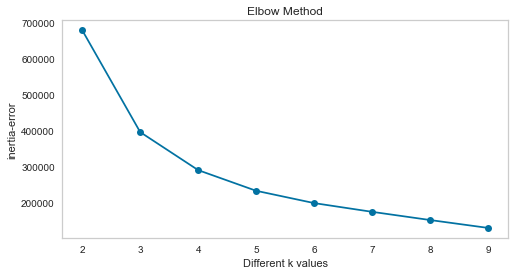

In [265]:
plt.figure(figsize=(8,4))
plt.plot(K, ssd, "bo-")
plt.xlabel("Different k values")
plt.ylabel("inertia-error")
plt.title("Elbow Method")
plt.grid()
plt.show()

### > **Elbow Method with yellowbrick**

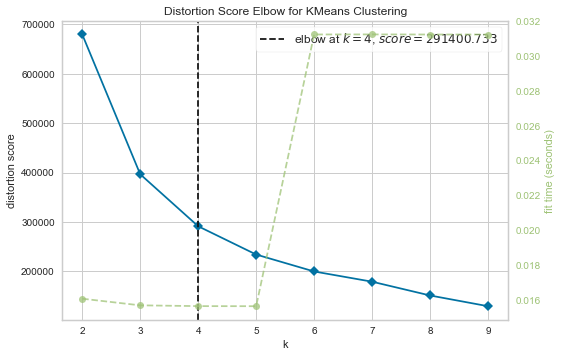

In [266]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k = (2,10))
visu.fit(df)
visu.show();

#### *iii. Apply K Means*

In [267]:
kmeans = KMeans(n_clusters = 4).fit(df)
labels = kmeans.labels_

#### *iv. Visualizing and Labeling All the Clusters*

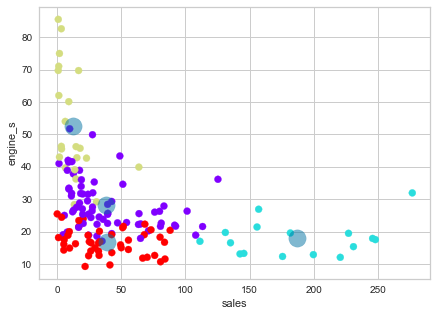

In [268]:
plt.figure(figsize=(7,5))
plt.scatter(df.iloc[:,0],df.iloc[:,1],c=kmeans.labels_,cmap="rainbow")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300,alpha=0.5, label = 'Centroids')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[2])
plt.show()

“k-means algoritması, çeşitli nedenlerden dolayı kategorik verilere doğrudan uygulanamaz. Kategorik veriler için sample ayrıktır ve Öklid mesafesi anlamlı değildir.”

### Hierarchical Clustering

#### *i. Determine optimal number of clusters using Dendogram*

**Hierarchy Clustering**

In [269]:
# hc_complete =  linkage(df,"complete")
hc_ward = linkage(df, "ward")
# hc_single = linkage(df, "single")

> **`ward`**

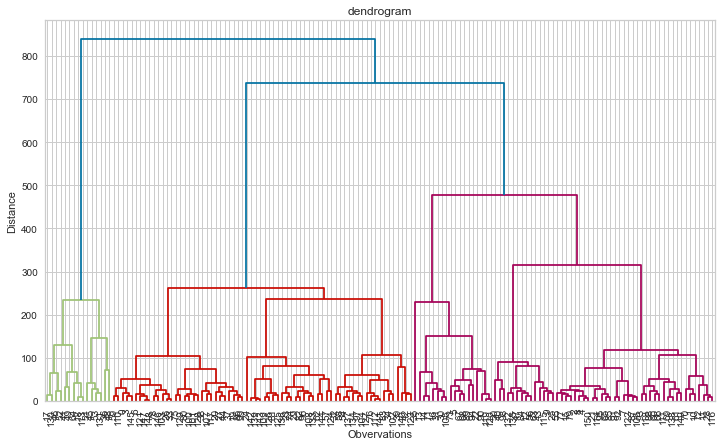

In [270]:
plt.figure(figsize = (12,7))
plt.title("dendrogram")
plt.xlabel("Obvervations")
plt.ylabel("Distance")
dendrogram(hc_ward, leaf_font_size = 10);

#### ii. *Apply Agglomerative Clustering*

In [271]:
hc = AgglomerativeClustering(n_clusters = 3,affinity='euclidean',linkage='ward') # burada default linkage='ward' dur.
hc.fit_predict(df)

array([2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0,
       0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 1, 2, 0,
       2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0],
      dtype=int64)

In [272]:
print(f'Silhouette Score(n=5): {silhouette_score(df, hc.labels_)}')

Silhouette Score(n=5): 0.36972092639969356


In [273]:
df["hc_clusters"] = hc.labels_
df.sample(3)

,sales,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,hc_clusters
6,1.380,62.0,4.2,310.0,113.0,74.0,198.2,3.902,23.7,21.0,0.322,0
66,15.467,42.8,3.0,240.0,114.5,71.6,191.3,3.650,18.4,21.0,2.739,0
149,5.596,17.5,2.0,115.0,98.9,68.3,163.3,2.762,14.6,26.0,1.722,2


In [274]:
df.groupby('hc_clusters').mean()

,sales,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales
hc_clusters,,,,,,,,,,,
0,31.755235,37.776044,3.727941,231.426471,108.826471,72.563235,191.088235,3.732603,19.301471,22.026471,2.854529
1,191.558467,17.992400,2.846667,151.333333,109.973333,71.093333,189.380000,3.203000,17.860000,24.866667,5.226733
2,37.313015,18.953603,2.392647,145.058824,104.979412,69.495588,181.967647,3.045250,16.533824,25.516176,3.251779


**`K-Means`**

In [275]:
kmeans = KMeans(n_clusters = 3).fit(df.iloc[:,:-1])
kmeans.fit_predict(df.iloc[:,:-1])
labels = kmeans.labels_
df["kmeans_clusters"] = labels

In [276]:
df.groupby('kmeans_clusters').mean()

,sales,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,hc_clusters
kmeans_clusters,,,,,,,,,,,,
0,175.336421,19.129000,3.000000,157.894737,111.126316,71.721053,191.763158,3.315895,18.347368,24.157895,5.124053,0.894737
1,20.875718,44.915333,4.005128,256.692308,109.317949,72.761538,191.553846,3.831051,19.948718,21.128205,2.433897,0.000000
2,36.822290,21.638204,2.641935,159.784946,105.522581,70.172043,183.810753,3.188452,16.968817,24.977419,3.240333,1.440860


 **K_Means vs HC**

In [277]:
pd.crosstab(df.kmeans_clusters,df.hc_clusters)

hc_clusters,0,1,2
kmeans_clusters,,,
0,3,15,1
1,39,0,0
2,26,0,67


#### iii. *Visualizing and Labeling All the Clusters* 

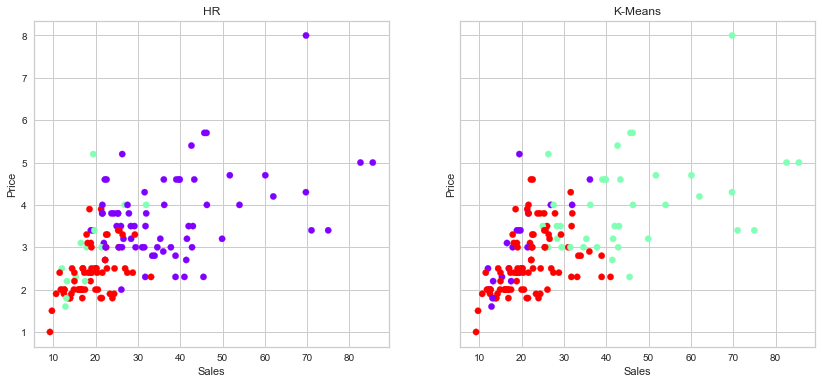

In [278]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,6)) # sharey=True ile y eksen labels lari ortak kullanirlar.
ax1.set_title('HR')
ax1.set_xlabel('Sales')
ax1.set_ylabel('Price')
ax1.scatter(df.iloc[:,1], df.iloc[:,2], c = df.hc_clusters, s = 40, cmap = "rainbow") # s=40 ,dot size
ax2.set_title("K-Means")
ax2.set_xlabel('Sales')
ax2.set_ylabel('Price')
ax2.scatter(df.iloc[:,1], df.iloc[:,2], c = df.kmeans_clusters, s = 40, cmap = "rainbow");

In [279]:
# HC Clustering
silhouette_score(df.drop(['kmeans_clusters','hc_clusters'],axis=1), hc.fit_predict(df))

0.36972092639969356

In [280]:
# K-Means Clustering
silhouette_score(df.drop(['kmeans_clusters','hc_clusters'],axis=1), kmeans.fit_predict(df))

0.40240324063334215

> **We can say K-means Clustering Model is more succesful. Its S Score is higher than HC**

**Visualization of Clusters in 3D**

In [281]:
df.head()

,sales,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,hc_clusters,kmeans_clusters
0,16.919,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,2,2
1,39.384,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0,1
3,8.588,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0,1
4,20.397,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,2,2
5,18.780,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0,2


In [282]:
from mpl_toolkits.mplot3d import Axes3D

kmeans= KMeans(n_clusters=3).fit(df.drop(['kmeans_clusters','hc_clusters'],axis=1))
clusters= kmeans.labels_
centers = kmeans.cluster_centers_

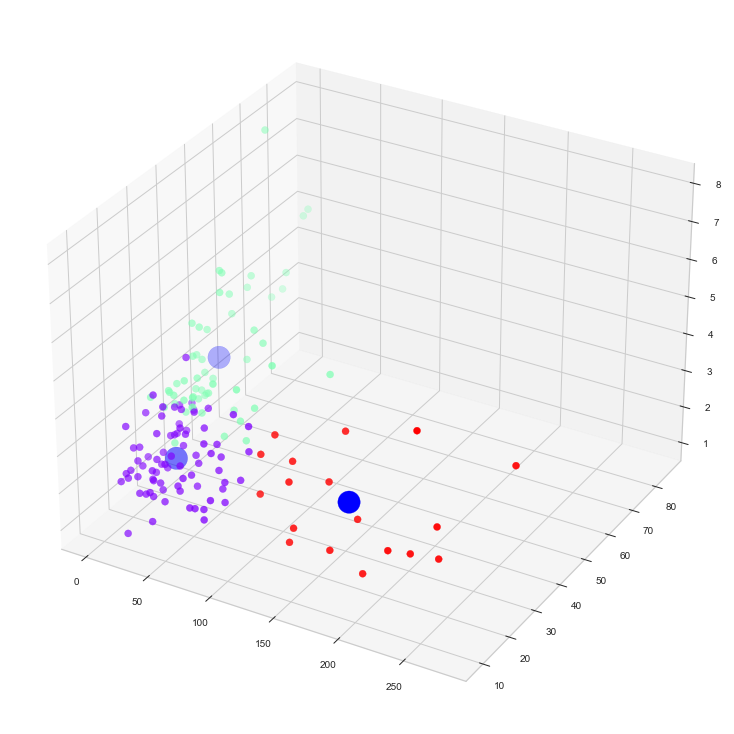

In [283]:
plt.rcParams["figure.figsize"] =(10,10)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df.iloc[:,0],df.iloc[:,1],df.iloc[:,2],c = clusters, s = 50,cmap = "rainbow")
ax.scatter(centers[:,0],centers[:,1],centers[:,2],c="blue",marker="o",s = 500);

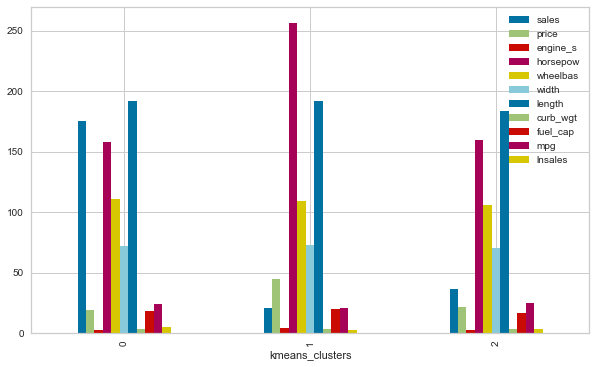

In [284]:
df.drop(['kmeans_clusters','hc_clusters'],axis=1).groupby(df.kmeans_clusters).mean().plot(figsize = (10,6), kind='bar')
plt.show()

### Conclusion

**1st group(Orange):**

**2nd group(Green):**

**3rd group(Blue):** 


It is obvious that we have 3 main clusters with the majority of vehicles in those.

Cars:

Cluster 1: with almost high mpg, and low in horsepower.
Cluster 2: with good mpg and horsepower, but higher price than average.
Cluster 3: with low mpg, high horsepower, highest price.

Trucks:

Cluster 1: with almost highest mpg among trucks, and lowest in horsepower and price.
Cluster 2: with almost low mpg and medium horsepower, but higher price than average.
Cluster 3: with good mpg and horsepower, low price.